In [20]:
import re
import random
import pandas as pd
import hashlib

In [21]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [22]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Email Auth and Security,509.094666,63.636833,112.857521,8
Debugging in VS Code,1037.921615,94.356510,192.682127,11
Logging in Python,1233.565281,88.111806,236.782737,14
VMWare,1293.228837,30.075089,61.430754,43
Azure Private DNS,1301.667783,68.508831,148.164822,19
Azure AD Authentication,1315.916121,101.224317,265.496133,13
Azure Functions + Visual Studio,1400.126207,107.702016,211.382063,13
C# Basics,1457.069253,47.002234,93.652805,31
RAG Project,1578.440519,98.652532,220.454826,16
Azure Compute Gallery,1894.782137,47.369553,110.213586,40


# Histogram

sum of ages: ~56370.80


<Axes: >

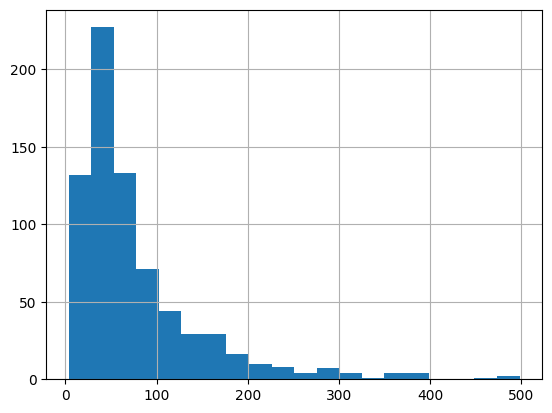

In [23]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [24]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [25]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [26]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [27]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [28]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [29]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [30]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [31]:
n=3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 726
Total card age: 56370.80


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
96,Azure Developer Associate,Why choose Azure Container Apps instead of Azu...,8c3d7ea082d3ab09d66623077af2f1b9,-497.966441,90.753671,497.966441,-7804.815679,0.640171,0,0
97,Azure Developer Associate,Give one example of a custom Azure Monitor met...,7a529ef9c9748a5eb52c9998e5812af7,-383.562897,90.753671,497.966441,-7804.815679,0.640171,3,0
98,Azure Developer Associate,Which messaging solution supports 2 MB message...,d6300c90de8219d8bfc05bbf5aa8a213,-299.593890,90.753671,497.966441,-7804.815679,0.640171,6,0
99,Azure Developer Associate,Front: You run a cross-partition query over 8 ...,826d464818843a41cec765b2c6446eef,-239.265755,90.753671,497.966441,-7804.815679,0.640171,9,0
100,Azure Developer Associate,What Azure Monitor feature routes platform log...,5208880711caac6907d82731a1e43cd9,-221.813450,90.753671,497.966441,-7804.815679,0.640171,12,0
101,Azure Developer Associate,What Azure CLI command allows CORS from https:...,95d2a75240a646635b69d89fe62896ef,-175.278716,90.753671,497.966441,-7804.815679,0.640171,15,0
102,Azure Developer Associate,What allows Azure App Service to integrate wit...,32290ecad251ac5c55d4207a493f2f7e,-120.793039,90.753671,497.966441,-7804.815679,0.640171,18,0
103,Azure Developer Associate,Which caching pattern loads data on demand int...,835f5f7d231724bc9594429a4497baf5,-102.009526,90.753671,497.966441,-7804.815679,0.640171,21,0
104,Azure Developer Associate,What feature lets you validate a Linux Web App...,06cf52a8b21987984aeeda225ca20257,-96.598700,90.753671,497.966441,-7804.815679,0.640171,24,0
105,Azure Developer Associate,What three steps secure and document partner A...,03f5c9f6e718395acceb4aa53e17b0c9,-87.148446,90.753671,497.966441,-7804.815679,0.640171,27,0


## Age Mean

In [32]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [33]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [34]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [35]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [36]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
96,Azure Developer Associate,Why choose Azure Container Apps instead of Azu...,8c3d7ea082d3ab09d66623077af2f1b9,-497.966441,90.753671,497.966441,-7804.815679,0.640171,0,0
345,Azure Developer Associate,Where do you associate a stored access policy ...,902bb129e8b619f0bbcf5a9a924c2230,-479.163402,90.753671,497.966441,-7804.815679,0.640171,1,1
26,Azure Functions + PP365,HTTP Triggers\nA type of function trigger that...,b9e42ab2e8e591023bd1aa43b8509bfc,-451.071315,98.344625,451.071315,-2065.237131,0.085122,0,0
58,PnP PowerShell,Secure Password Handling\nPractices for managi...,274158ed857c87a86d296e65705f10da,-398.340041,90.063073,398.340041,-5403.784352,0.985939,0,0
584,Azure Developer Associate,What are the two primary data types collected ...,f0995a4e3eae52ece78cb2f025efcf7f,-385.210896,90.753671,497.966441,-7804.815679,0.640171,2,2
97,Azure Developer Associate,Give one example of a custom Azure Monitor met...,7a529ef9c9748a5eb52c9998e5812af7,-383.562897,90.753671,497.966441,-7804.815679,0.640171,3,0
346,Azure Developer Associate,Which Azure storage service supports a user de...,fd19a76de5cbe2ba07dc309378571330,-381.550765,90.753671,497.966441,-7804.815679,0.640171,4,1
277,Azure Functions + PP365,Virtual Environment Activation\nThe process of...,f4ebac7aac964a3452e1734f5f37fcea,-373.091682,98.344625,451.071315,-2065.237131,0.085122,1,1
585,Azure Developer Associate,What’s the maximum retention you can configure...,d5ee457fbd0609a88312665b94d8621e,-372.447268,90.753671,497.966441,-7804.815679,0.640171,5,2
39,Python,Q:\nWhat are the two essential methods that an...,558bcbe4e40c504fe6e977eb903fb48d,-354.087103,96.755956,354.087103,-3096.190579,0.657645,0,0


In [37]:
existing_cards.head(10).sum()

head                   Azure Developer AssociateAzure Developer Assoc...
body                   Why choose Azure Container Apps instead of Azu...
hash                   8c3d7ea082d3ab09d66623077af2f1b97a529ef9c9748a...
age                                                         -2224.030861
subject_mean_age                                              907.536707
subject_highest_age                                          4979.664414
subject_age_sum                                             -78048.15679
head_random_roll                                                6.401712
count                                                                135
n_fold                                                                 0
dtype: object

In [38]:
existing_cards['age'].mean()

-77.64573683379798